In [46]:
# Import relevant dependencies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import glob

# Set up plotting
plt.style.use("ggplot")

**Data Pre-Processing**: Code to write JSON data into CSV format

```python
# Set data path
DATA_PATH = r"../data/streaming/endsong_*.json"

# Gather all JSON files into list
all_data = []
for fname in glob.glob(DATA_PATH):
    with open(fname) as f:
        all_data.extend(json.load(f))
        
# Organize into Pandas DataFrame
df = pd.DataFrame(all_data)

# Sort by time and re-index
df.sort_values("ts").reset_index(inplace=True)

# Write DataFrame to CSV file
df.to_csv("../data/streaming/stream.csv", index=False)
```

|Technical Field|Description|
|:----|:----|
|ts|This field is a timestamp indicating when the track stopped playing in UTC (Coordinated Universal Time). The order is year, month and day followed by a timestamp in military time|
|username|This field is your Spotify username.|
|platform|This field is the platform used when streaming the track (e.g. Android OS, Google Chromecast).|
|ms_played|This field is the number of milliseconds the stream was played.|
|conn_country|This field is the country code of the country where the stream was played (e.g. SE - Sweden).|
|Ip_addr_decrypted|This field contains the IP address logged when streaming the track.|
|user_agent_decrypted|This field contains the user agent used when streaming the track (e.g. a browser, like Mozilla Firefox, or Safari)|
|master_metadata_track_name|This field is the name of the track.|
|master_metadata_album_artist_name|This field is the name of the artist, band or podcast.|
|master_metadata_album_album_name|This field is the name of the album of the track.|
|spotify_track_uri|A Spotify URI, uniquely identifying the track in the form of “spotify:track:<base-62 string>” A Spotify URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track.|
|episode_name|This field contains the name of the episode of the podcast.|
|episode_show_name|This field contains the name of the show of the podcast.|
|spotify_episode_uri|A Spotify Episode URI, uniquely identifying the podcast episode in the form of “spotify:episode:<base-62 string>” A Spotify Episode URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an episode of a podcast.|
|reason_start|This field is a value telling why the track started (e.g. “trackdone”)|
|reason_end|This field is a value telling why the track ended (e.g. “endplay”).|
|shuffle|This field has the value True or False depending on if shuffle mode was used when playing the track.|
|skipped|This field indicates if the user skipped to the next song|
|offline|This field indicates whether the track was played in offline mode (“True”) or not (“False”).|
|offline_timestamp|This field is a timestamp of when offline mode was used, if used.|
|incognito_mode|This field indicates whether the track was played in incognito mode (“True”) or not (“False”).|


In [2]:
df = pd.read_csv("../data/streaming/stream.csv", parse_dates=['ts']).set_index('ts')

# Create a seconds played column
df['sec_played'] = round(df['ms_played'] / 1000, 1)

/var/folders/vv/y4qqcpt53lx2zq975gbgl3f80000gn/T/ipykernel_4583/2400650992.py:1: DtypeWarning: Columns (11,12,13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/streaming/stream.csv", parse_dates=['ts']).set_index('ts')


In [ ]:
df['conn_country'].value_counts()

In [ ]:
df["master_metadata_album_artist_name"].value_counts()

In [43]:
# Group Streaming History by Artist name sorted by listening time
top_minutes = df.groupby(
    "master_metadata_album_artist_name").sum().sort_values(
    by="ms_played", ascending=False)[['ms_played']]

# Get names of top five artists
num_top_artists = 5
top_artist_names = set(top_minutes.index[:num_top_artists])

# Create DataFrame of streaming history from top five artists
top_five = df[df['master_metadata_album_artist_name'].isin(top_artist_names)]

# Quantize streaming history to daily basis
top_five_daily = top_five.groupby([
    pd.Grouper(freq='D'),
    pd.Grouper(key='master_metadata_album_artist_name'),
]).sum()[["sec_played"]]

# Get cumulative time spent over history
top_five_daily_cumulative = top_five_daily.groupby("master_metadata_album_artist_name").cumsum()

# Explode Album index for plotting purposes
top_five_daily_reduced = top_five_daily_cumulative.reset_index(level=1)

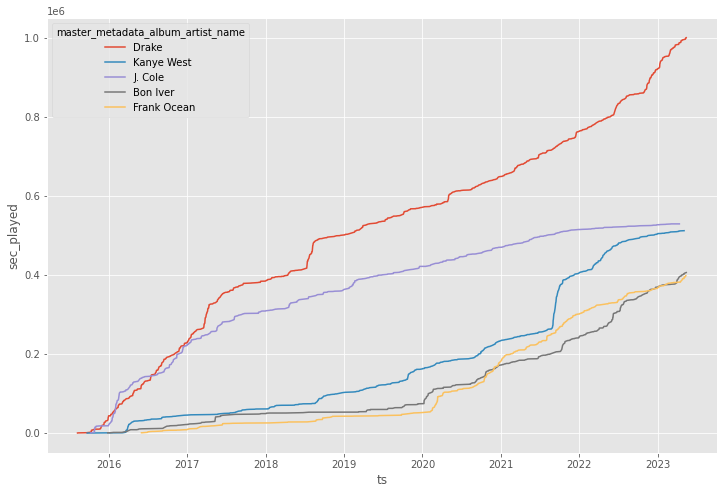

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot cumulative listening over time
sns.lineplot(
    data=top_five_daily_reduced, 
    x=top_five_daily_reduced.index,
    y="sec_played",
    hue="master_metadata_album_artist_name",
    ax=ax
);